# 연습문제 3-2

## 다음은 부산광역시 어린이집 현황의 일부이다. 어린이집유형 속성과 어린이집특성 속성 간의 연관성 여부를 유의수준 0.05 수준에서 카이제곱 검정 방법에 의해 판단해 보시오.

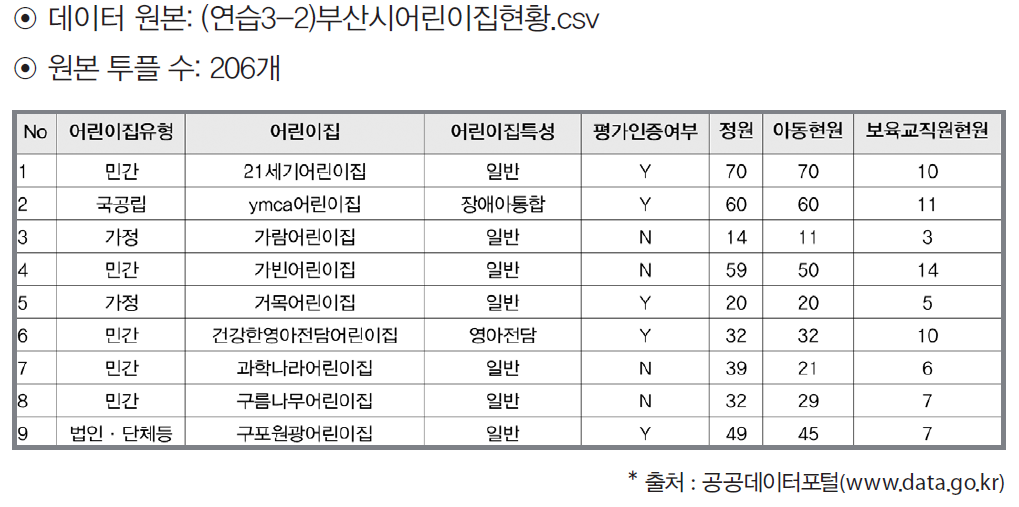

In [2]:
# ex3-2.ipynb
import pandas as pd
import numpy as np
import cx_Oracle      # Oracle DB 연동을 위한 cx_Oracle 패키지 임포트

# 데이터로드 ((연습3-2)부산시어린이집현황.csv : 데이터 원본 파일)
# encoding : 윈도우즈 환경에서의 한글 처리
# engine : python 3.6에서 한글이 포함된 파일이름 사용
rawData_org = pd.read_csv('연습문제파일/(연습3-2)부산시어린이집현황.csv', encoding='CP949', engine='python')

In [3]:
rawData_org

,No,어린이집유형,어린이집,어린이집특성,평가인증여부,정원,아동현원,보육교직원현원
0,1,민간,21세기어린이집,일반,Y,70,70,10
1,2,국공립,ymca어린이집,장애아통합,Y,60,60,11
2,3,가정,가람어린이집,일반,N,14,11,3
3,4,민간,가빈어린이집,일반,N,59,50,14
4,5,가정,거목어린이집,일반,Y,20,20,5
...,...,...,...,...,...,...,...,...
201,202,민간,화명숲어린이집,일반,N,64,64,12
202,203,국공립,화명어린이집,일반,Y,83,79,10
203,204,국공립,화명초등어린이집,일반,Y,49,46,7
204,205,민간,화영어린이집,일반,Y,95,77,14


In [4]:
# 원본 데이터파일에서 '어린이집유형'과 '어린이집특성'  속성만 추출
rawData = rawData_org.loc[:,['어린이집유형','어린이집특성']]

In [5]:
rawData

,어린이집유형,어린이집특성
0,민간,일반
1,국공립,장애아통합
2,가정,일반
3,민간,일반
4,가정,일반
...,...,...
201,민간,일반
202,국공립,일반
203,국공립,일반
204,민간,일반


In [6]:
# Oracle DB 연결
# 접속정보(connection string) : ID/PASS@CONNECTION_ALIAS
# CONNECTION_ALIAS : Oracle TNSNAMES.ORA 파일에 있는 접속정보 별칭(ALIAS)
conn_ora = cx_Oracle.connect("prep1/prep1@XE")

# DB 커서(Cursor) 선언
cur = conn_ora.cursor()

# 사용할 Oracle 소스 테이블명 지정
src_table = "ex_base3_2"

# 데이터프레임(rawData)에 저장된 데이터를 Oracle 테이블(d_base3_2)에 입력하기 위한 로직
# d_base3_2 테이블 존재하는지 체크하는 함수
def table_exists(name=None, con=None):
    sql = "select table_name from user_tables where table_name='MYTABLE'".replace('MYTABLE', name.upper())
    df = pd.read_sql(sql, con)

    # 테이블이 존재하면 True, 그렇지 않으면 False 반환
    exists = True if len(df) > 0 else False
    return exists

# 테이블(d_base3_2) 생성 (테이블이 이미 존재한다면 TRUNCATE TABLE)
if table_exists(src_table, conn_ora):
    cur.execute("TRUNCATE TABLE " + src_table)
else:
    cur.execute("create table " + src_table + " ( \
               어린이집유형 varchar2(20), \
               어린이집특성 varchar2(30))")

# Sequence 구조를 Dictionary 구조((element, value))로 변환하는 함수
# 예: ("Matt", 1) -> {'1':'Matt', '2':1}
# INSERT INTO ... VALUES (:1, :2, ...) 에서 바인드 변수값을 주기위해 Dictionary item 구조 사용
def convertSequenceToDict(list):
    dict = {}
    argList = range(1, len(list) + 1)
    for k, v in zip(argList, list):
        dict[str(k)] = v
    return dict

# 데이터프레임에 저장된 데이터를 Oracle 테이블로 입력(insert)
cols = [k for k in rawData.dtypes.index]
colnames = ','.join(cols)
colpos = ', '.join([':' + str(i + 1) for i, f in enumerate(cols)])
insert_sql = 'INSERT INTO %s (%s) VALUES (%s)' % (src_table, colnames, colpos)

# INSERT INTO ... VALUES (:1, :2, ...)의 바인드 변수 값을 저장하는 Dictionary 구조 생성
data = [convertSequenceToDict(rec) for rec in rawData.values]

# 바인드 변수와 Dictionary 데이터구조를 활용하여 Bulk Insertion 구현
cur.executemany(insert_sql, data)
conn_ora.commit()

### 실무예제 2-2의 Oracle 연동 설명 참조
### Oracle sqlplus를 통해서 d_base3_2 테이블 생성 확인

In [7]:
# 관측도수/기대도수 분할표 생성 (1차원 배열 형식)
count_df = pd.read_sql("select a.어린이집유형 \
                        , a.어린이집특성 \
                        , nvl(b.관측도수,0) 관측도수 /*관측되지않은 (어린이집유형+어린이집특성)은 0으로 처리*/ \
                        , a.기대도수_유형 * a.기대도수_특성 / a.기대도수_전체 기대도수 \
                      from ( \
                             select x.어린이집유형, y.어린이집특성 \
                                  , x.기대도수_유형 \
                                  , y.기대도수_특성 \
                                  , x.기대도수_전체 \
                             from ( select 어린이집유형 \
                                         , count(*) 기대도수_유형 /* 어린이집유형 속성의 cardinality */ \
                                         , sum(count(*)) over () 기대도수_전체 /* 전체 행 개수 */ \
                                    from " + src_table + " \
                                    group by 어린이집유형 ) x, \
                           ( select 어린이집특성 \
                                  , count(*) 기대도수_특성 /* 어린이집특성 속성의 cardinality */ \
                             from " + src_table + " \
                             group by 어린이집특성 ) y ) a, \
                           ( select 어린이집유형 \
                                  , 어린이집특성 \
                                  , count(*) 관측도수 /* 어린이집유형, 어린이집특성 별 실제 행 개수 */ \
                             from " + src_table + " \
                             group by 어린이집유형, 어린이집특성 ) b \
                      where a.어린이집유형 = b.어린이집유형(+) /* 특정 (어린이집유형+어린이집특성) 값은 존재하지 않을 수 \
                                                있어서 외부조인으로 처리 */ \
                           and a.어린이집특성 = b.어린이집특성(+)", con=conn_ora)

### pandas 데이터프레임에 카이제곱 검정을 위한 관측도수/기대도수 분할표 저장
### ‘시군’ 속성 ‘지정구분’ 속성에 대한 관측도수와 기대도수를 구하기 위해서 Oracle SQL을 활용
#### 관측도수 :  ‘시군’과 ‘지정구분’ 속성값의 조합에 대한 실제 출현횟수
#### 기대도수 : 전체 행의 개수와 각 속성의 카디널러티(cardinality, 서로 다른 속성값의 개수)를 구하여 산출
#### 실제 출현하지 않은 (시군+지정구분) 속성값도 포함시키기 위해서 외부조인(outer join)을 수행

In [8]:
# 관측도수/기대도수 분할표 출력
count_df

,어린이집유형,어린이집특성,관측도수,기대도수
0,법인·단체등,일반,1,0.907767
1,국공립,시간연장형,2,0.310680
2,사회복지법인,일반,2,6.354369
3,민간,장애아통합,1,1.194175
4,사회복지법인,영아전담,1,0.067961
5,민간,장애아전문,1,1.194175
6,가정,시간연장형,4,4.116505
7,민간,시간연장형,2,3.184466
8,국공립,장애아통합,2,0.116505
9,가정,일반,101,96.223301


In [9]:
# 2개 속성에 대한 자유도(degree of freedom) 갭 구하기
# A 속성에 대한 cardinality = a, B 속성에 대한 cardinality = b라 가정
# cardinality : 서로 다른 속성값의 개수
# 분할표 전체 행 갯수(a*b) 구하기
tot_rows = count_df.shape[0]

### ‘어린이집유형’ 속성의 카디널러티(a) = 7
### ‘어린이집특성’ 속성의 카디널러티(b) = 8
### 그래서, (어린이집유형+어린이집특성) 속성조합의 카디널러티(a\*b) = 7 * 8 = 56

In [10]:
tot_rows  # 변수확인

56

In [11]:
# A 속성의 cardianlity(a)와 B 속성의 cardinality(b) 구하기
count_df2 = pd.read_sql("select count(distinct 어린이집유형) 도수_유형 \
                           , count(distinct 어린이집특성) 도수_특성\
                      from " + src_table , con=conn_ora)

In [12]:
count_df2  # 변수확인

,도수_유형,도수_특성
0,7,8


In [13]:
# cardinality 갭 [(a*b-1) - (a-1)*(b-1)] 구하기
v_ddof = (tot_rows - 1) - (count_df2['도수_유형']-1)*(count_df2['도수_특성']-1)

### 속성조합의 자유도(degree of freedom) = (56-1) = 55
### 실제 자유도는 (7-1) * (8-1) = 42
### 위 두 값의 차이 : 13 -> chisquare() 함수의 세번째 패러미터로 사용

In [14]:
v_ddof  # 변수확인

0    13
dtype: int64

In [15]:
obs_array = count_df['관측도수'] # obs_array : 관측도수를 저장하는 1차원 배열

### obs_array : chisquare() 함수의 첫번째 패러미터로 사용

In [16]:
obs_array  # 변수확인

0       1
1       2
2       2
3       1
4       1
5       1
6       4
7       2
8       2
9     101
10      1
11      1
12     77
13      1
14      1
15      2
16      1
17      4
18      1
19      0
20      0
21      0
22      0
23      0
24      0
25      0
26      0
27      0
28      0
29      0
30      0
31      0
32      0
33      0
34      0
35      0
36      0
37      0
38      0
39      0
40      0
41      0
42      0
43      0
44      0
45      0
46      0
47      0
48      0
49      0
50      0
51      0
52      0
53      0
54      0
55      0
Name: 관측도수, dtype: int64

In [17]:
exp_array = count_df['기대도수'] # exp_array : 기대도수를 저장하는 1차원 배열

### exp_array : chisquare() 함수의 두번째 패러미터로 사용

In [18]:
exp_array  # 변수확인

0      0.907767
1      0.310680
2      6.354369
3      1.194175
4      0.067961
5      1.194175
6      4.116505
7      3.184466
8      0.116505
9     96.223301
10     0.907767
11     0.907767
12    74.436893
13     0.796117
14     0.033981
15     0.101942
16     0.033981
17     7.262136
18     0.514563
19     0.038835
20     0.077670
21     0.009709
22     0.004854
23     0.004854
24     1.543689
25     0.038835
26     0.004854
27     0.116505
28     0.271845
29     0.014563
30     0.004854
31     0.038835
32     1.543689
33     0.101942
34     0.014563
35     0.514563
36     0.004854
37     0.009709
38     0.398058
39     0.004854
40     0.014563
41     0.038835
42     0.398058
43     0.038835
44     0.004854
45     0.009709
46     0.014563
47     0.004854
48     0.014563
49     0.033981
50     1.029126
51     0.014563
52     0.038835
53     0.514563
54     0.004854
55     0.398058
Name: 기대도수, dtype: float64

In [19]:
# 카이제곱검정을 위한 scipy 패키지 중 stats 모듈 임포트
from scipy import stats

In [20]:
# stats.chisquare() : 카이제곱검정 함수
chis = stats.chisquare(obs_array, exp_array, ddof=v_ddof)

### chisquare() 함수 : 카이제곱(χ2) 통계량을 산출하는 함수
#### 첫번째 패러미터 : 1차원 배열 형태의 관측도수 리스트
#### 두번째 패러미터 : 1차원 배열 형태의 기대도수 리스트
#### 세번째 패러미터 : 자유도 차이 [(a\*b-1) - (a-1)\*(b-1)]

In [21]:
# stats.chisquare() 수행 후의 카이제곱 통계량과 p-value
print("statistic = %.3f, p-value = %.20f" % (chis))

statistic = 155.838, p-value = 0.00000000000000541185


### 카이제곱 통계량(statistic) : 155.838
### 유의확률(p-value) : 0.00000000000000541185
### 유의수준 0.05로 설정한다면 대립가설(두 속성은 연관성이 있다)이 채택되며 유의수준에 비해 유의확률이 매우 낮음. 결론적으로, 어린이집유형과 어린이집특성 사이에는 강한 연관성이 있는 것으로 판단할 수 있음.